# Digit recognizer: Model comparison and hyperparameter tuning

This project aims to develop a machine learning model for recognising handwritten digits and is part of the Kaggle competition [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer). The [MNIST](http://yann.lecun.com/exdb/mnist/index.html) dataset, the de facto “hello world” dataset of computer vision, is used to train and test the models.

We compare different machine learning models: logistic regression, fully connected neural network, and convolutional neural network. We also perform hyperparameter tuning to achieve the best performance.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import sys
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from timeit import default_timer as timer
from utils import *

mpl.rcParams.update({'font.size': 13})

print('Python version', sys.version.split()[0])

Python version 3.8.7


# Import and preprocess data

The data files train.csv and test.csv contain grey-scale images of handwritten digits, from zero to nine. The training and test sets have 42000 and 28000 images, respectively. Each image has 28 pixels in height and 28 pixels in width, with 784 pixels in total. Each pixel-value is an integer between 0 and 255, inclusive. The first column of the training set is the digit label.

In [2]:
# Import training and test sets
folder = './'
# folder = '/kaggle/input/digit-recognizer/'

train = pd.read_csv(folder + 'train.csv')
X_train = train.iloc[:,1:]
Y_train = train.iloc[:,0]

X_test = pd.read_csv(folder + 'test.csv')

n_px = int(X_train.shape[1]**0.5)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('N. of pixels', n_px)

Training set shape: (42000, 784)
Test set shape: (28000, 784)
N. of pixels 28


In [44]:
def plot_digits(X, Y, n_digits):
    '''Plots the specified number of digits randomly selected from the data set and corresponding labels.'''

    # Select a random sample of digits
    idxs = np.random.randint(0, X.shape[0], n_digits)
    X_s = X[idxs]
    Y_s = Y[idxs]

    # Number of rows and columns
    n_cols = 10
    n_rows = math.ceil(n_digits/n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,2.5*n_rows), squeeze=False)
    i_digit = 0

    for i_row in range(n_rows):
        for i_col in range(n_cols):

            ax = axs[i_row,i_col]

            if i_digit >= n_digits:
                ax.axis('off')
                continue

            # Reshape the pixels vector into a matrix
            px = X_s[i_digit].reshape((n_px,-1))
            
            # Plot the digit
            ax.imshow(px, cmap='gray_r')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(Y_s[i_digit])

            i_digit += 1

The following images show some handwritten digits and the corresponding labels.

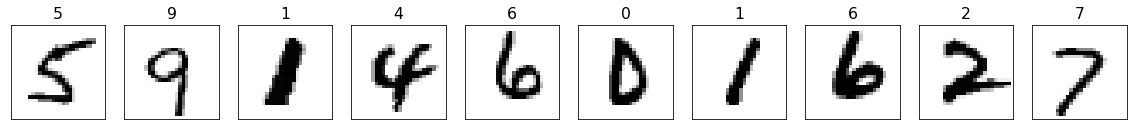

In [45]:
plot_digits(X_train.values, Y_train.values, 10)

In [5]:
# Scale and center the data
X_train = X_train/255 - 0.5
X_test = X_test/255 - 0.5

We will split the current training set into a new training set and a validation set to assess the machine learning models' performance. We will use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function of the Scikit-learn library. By dividing the initial data into three sets, we reduce the data available for training the model. [Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) procedures can be used to mitigate this. Since a large data set is used in this project, and to keep a reasonable execution time of this notebook, this procedures won’t be applied here.

In [6]:
# Split original training set into training and validation sets
X_train_o = X_train.copy()
Y_train_o = Y_train.copy()

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

# Model selection

We will try different machine learning models. Each algorithm has its strengths and weaknesses, and so we need to select the algorithm that works best with our specific data. We will compare the performance of the following algorithms:

* Logistic regression
* Fully connected feedforward neural network
* Convolutional neural network

The evaluation metric used to compare the different models is the categorization accuracy, i.e., the proportion of test images correctly classified.

## Logistic regression

The logistic regression classifier is easy to implement and understand, so it is a natural first choice. We will use the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class of the Scikit-learn library.

In [7]:
def fit_sklearn_model(model, X_train, Y_train, X_val=None, Y_val=None, display_info=True):
    '''
    Fits a Scikit-learn model to the training set and calculates its accuracy and training time.
    '''

    # Fit the model and calculate the training time
    start = timer()
    model.fit(X_train, Y_train)
    time = timer() - start

    # Calculate the accuracies
    train_accuracy = accuracy_score(Y_train, model.predict(X_train))

    if X_val is not None:
        val_accuracy = accuracy_score(Y_val, model.predict(X_val))
    else:
        val_accuracy = None

    # Display information of the training process
    if display_info:
        print('Train accuracy: {:.2%}'.format(train_accuracy), end='')
        if X_val is not None:
            print('; Validation accuracy: {:.2%}'.format(val_accuracy), end='')
        print('; Training time: {:.1f}s'.format(time))

    return train_accuracy, val_accuracy, time

In [8]:
# Create the logistic regression classifier
create_arg = {'random_state':0,'solver':'newton-cg'}
model = LogisticRegression(**create_arg)

# Fit the model
fit_arg = {'X_train':X_train,'Y_train':Y_train,'X_val':X_val,'Y_val':Y_val}

fit_sklearn_model(model, **fit_arg);

Train accuracy: 94.53%; Validation accuracy: 92.05%; Training time: 200.3s


The model’s accuracy on the validation set is higher than that on the training set. The model might be overfitting the data, so we will try different normalisation levels to improve this. We will use five values, spaced evenly on a log scale between 10<sup>-3</sup> and 10.

In [9]:
def compare_model_param(create_fun, create_arg, fit_fun, fit_arg, tuning_param, xscale='linear', xticks_labels=None):
    ''' Compares the models built with the specified hyperparameters.'''

    # Create and fit the models
    train_accuracies = []
    val_accuracies = []
    times = []

    for val in tuning_param[1]:

        model = create_fun(**create_arg, **{tuning_param[0]:val})

        outputs = fit_fun(model, **fit_arg)

        train_accuracies.append(get_last_elem(outputs[0]))
        val_accuracies.append(get_last_elem(outputs[1]))
        times.append(outputs[2])

    # Plot the accuracies and training times
    if xticks_labels is None:
        x = tuning_param[1]
    else:
        x = range(len(tuning_param[1]))

    fig = plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(x, train_accuracies)
    plt.plot(x, val_accuracies)
    plt.xscale(xscale)
    plt.xlabel(tuning_param[0])
    plt.xticks(x, xticks_labels)
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], frameon=False)
    set_spines()

    plt.subplot(1, 2, 2)
    plt.plot(x, times)
    plt.xscale(xscale)
    plt.xlabel(tuning_param[0])
    plt.xticks(x, xticks_labels)
    plt.ylabel('Training time (s)')
    set_spines()

Train accuracy: 88.57%; Validation accuracy: 89.24%; Training time: 13.1s
Train accuracy: 91.52%; Validation accuracy: 91.67%; Training time: 22.5s
Train accuracy: 93.35%; Validation accuracy: 92.44%; Training time: 46.9s
Train accuracy: 94.53%; Validation accuracy: 92.05%; Training time: 198.7s


C:\PortablePrograms\WinPython\3_8\python-3.8.7.amd64\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


Train accuracy: 95.33%; Validation accuracy: 91.26%; Training time: 341.5s


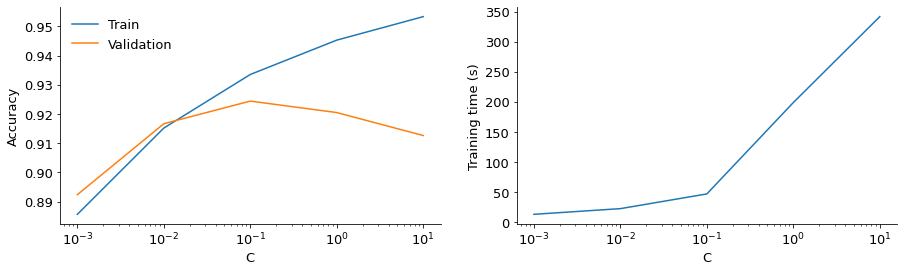

In [10]:
C = np.logspace(-3, 1, 5)
compare_model_param(LogisticRegression, create_arg, fit_sklearn_model, fit_arg, ('C',C), 'log')

A value of 0.1 led to the most accurate model. The [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) class of the Scikit-learn library can also be used to select the best C parameter using a K-Folds cross-validator. This approach might lead to slightly better results but might be significantly more computationally expensive.

Now let’s calculate the predictions for the test set.

In [11]:
# Create and fit the model using the optimised hyperparameter and the original training set
create_arg['C'] = 0.1

model = LogisticRegression(**create_arg)
fit_sklearn_model(model, X_train_o, Y_train_o);

# Predict class labels for test set and save them to file
def save_submission(Y_pred, filename):
    submission = pd.Series(Y_pred, index=range(1, len(Y_pred) + 1), name='Label')
    submission.to_csv(filename, index_label='ImageId')

save_submission(model.predict(X_test), 'submission_1.csv')

Train accuracy: 93.34%; Training time: 61.5s


The test set predictions were submitted to Kaggle, and an accuracy of 92.10% was obtained.

##  Fully connected feedforward neural network

Neural networks (NN) can model more complex structures in the data. However, there is generally a trade-off between interpretability and predictive power. The fully connected feedforward neural network was the first and most straightforward type. We will use the [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) class of the Scikit-learn library. We will start with one hidden layer with 100 units.

In [12]:
# Create the multi-layer perceptron classifier
create_arg = {'solver':'sgd','random_state':0}
model = MLPClassifier(**create_arg)

# Fit the model
fit_sklearn_model(model, **fit_arg);

Train accuracy: 97.19%; Validation accuracy: 95.79%; Training time: 148.8s


C:\PortablePrograms\WinPython\3_8\python-3.8.7.amd64\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Using a NN with default hyperparameters instead of the initial logistic regression classifier increased the accuracy on the validation set from 92.05% to 95.79% while being significantly faster. Now let's tune the initial value of the learning rate and keep that value constant during training.

In [13]:
def compare_mlp_loss(create_fun, create_arg, fit_fun, fit_arg, tuning_param, legend=None):

    # Set default legend
    if legend is None:
        legend = [str(val) for val in tuning_param[1]]

    # Create and fit the models
    for i, val in enumerate(tuning_param[1]):

        model = create_fun(**create_arg, **{tuning_param[0]:val})

        time = fit_fun(model, **fit_arg, display_info=False)[-1]
        
        plt.plot(range(1, len(model.loss_curve_) + 1), model.loss_curve_)

        print('Value: {}; Training time: {:.1f}s'.format(legend[i], time))

    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(legend, frameon=False)
    plt.title(tuning_param[0])
    set_spines()

C:\PortablePrograms\WinPython\3_8\python-3.8.7.amd64\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Value: 0.001; Training time: 148.7s
Value: 0.01; Training time: 139.9s
Value: 0.1; Training time: 39.4s


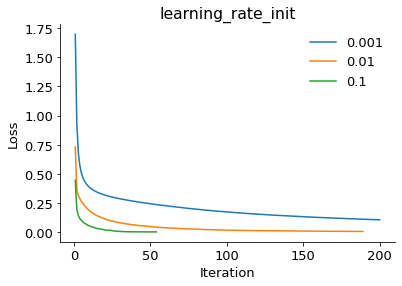

In [14]:
# Tune the initial learning rate
compare_mlp_loss(MLPClassifier, create_arg, fit_sklearn_model, fit_arg, ('learning_rate_init',[0.001,0.01,0.1]))

A value of 0.1 leads to the lowest loss and number of iterations. We can gradually decrease the learning rate during training to obtain more accurate models or a smoother variation of the loss function. We will use an inverse scaling exponent and tune the exponent value.

Value: 0; Training time: 39.5s
Value: 0.05; Training time: 56.1s
Value: 0.1; Training time: 90.0s


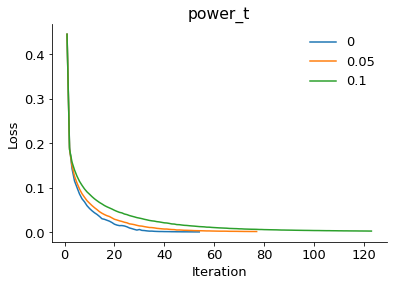

In [15]:
# Tune the learning rate schedule
create_arg['learning_rate_init'] = 0.1
create_arg['learning_rate'] = 'invscaling'
vals = [0,0.05,0.1]

compare_mlp_loss(MLPClassifier, create_arg, fit_sklearn_model, fit_arg, ('power_t',vals))

A value of 0.05 led to the best compromise between accuracy and smooth variation. Now let’s tune the batch size, i.e., the number of samples per gradient update.

Value: 128; Training time: 48.2s
Value: 256; Training time: 62.3s
Value: 512; Training time: 83.2s


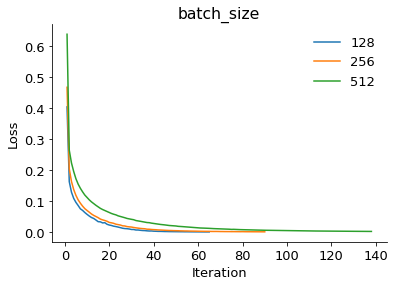

In [16]:
# Tune the batch size
create_arg['power_t'] = 0.05

compare_mlp_loss(MLPClassifier, create_arg, fit_sklearn_model, fit_arg, ('batch_size',[128,256,512]))

A value of 256 led to the best compromise between loss and smooth variation. Now let’s tune the number of hidden layer’s units.

Train accuracy: 100.00%; Validation accuracy: 97.52%; Training time: 89.1s
Train accuracy: 100.00%; Validation accuracy: 97.81%; Training time: 131.3s
Train accuracy: 100.00%; Validation accuracy: 97.73%; Training time: 189.5s


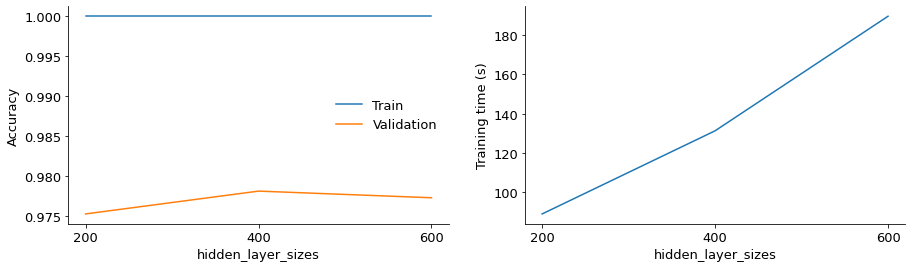

In [17]:
create_arg['batch_size'] = 256

vals = [(200,),(400,),(600,)]

compare_model_param(MLPClassifier, create_arg, fit_sklearn_model, fit_arg, ('hidden_layer_sizes',vals))

Using 400 neurons lead to the highest accuracy on the validation set. Let’s now try a NN with two layers.

Train accuracy: 100.00%; Validation accuracy: 97.61%; Training time: 111.2s
Train accuracy: 100.00%; Validation accuracy: 97.80%; Training time: 105.9s
Train accuracy: 100.00%; Validation accuracy: 97.24%; Training time: 147.5s


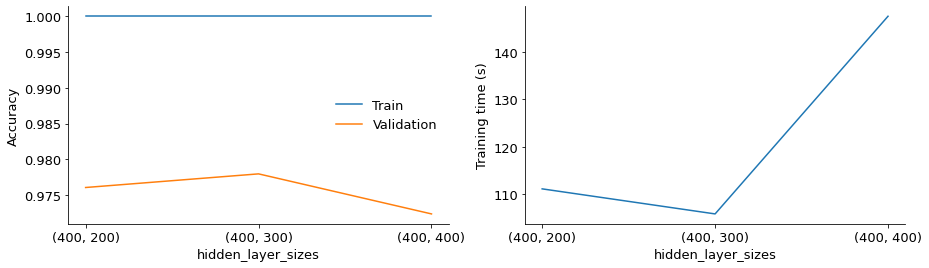

In [18]:
vals = [(400,200),(400,300),(400,400)]

compare_model_param(MLPClassifier, create_arg, fit_sklearn_model, fit_arg, ('hidden_layer_sizes',vals),
                    xticks_labels=[str(val) for val in vals])

The model with a second layer with 300 neurons led to the best results. The model’s accuracy on the validation set is significantly higher than that on the training set. The model might be overfitting the data, so we will try different normalisation values to improve this.

Train accuracy: 100.00%; Validation accuracy: 97.80%; Training time: 105.1s
Train accuracy: 100.00%; Validation accuracy: 97.86%; Training time: 144.9s
Train accuracy: 97.49%; Validation accuracy: 96.30%; Training time: 338.7s


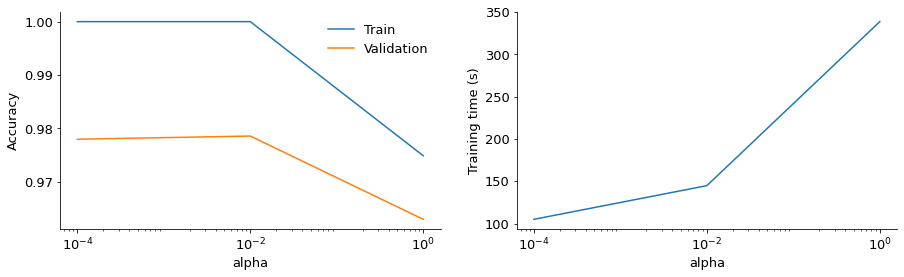

In [19]:
create_arg['hidden_layer_sizes'] = (400,300)

compare_model_param(MLPClassifier, create_arg, fit_sklearn_model, fit_arg, ('alpha',np.logspace(-4, 0, 3)), 'log')

Adding normalization didn’t improve the accuracy of the model, and so we will assume that the model is not overfitting the data. We could have used the classes [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) of the Scikit-learn library to tune the hyperparameters. These approaches might lead to more optimised hyperparameters but might be more computationally expensive. Also, the approach we followed allows a better understanding of how the different parameters influence our model's performance.

Now let’s calculate the predictions for the test set.

In [20]:
# Create and fit the model using the optimised hyperparameters and the original training set
model = MLPClassifier(**create_arg)
fit_sklearn_model(model, X_train_o, Y_train_o);

# Predict class labels for test set and save them to file
save_submission(model.predict(X_test), 'submission_2.csv')

Train accuracy: 100.00%; Training time: 126.0s


The test set predictions were submitted to Kaggle, and an accuracy of 97.85% was obtained.

## Convolutional neural network

Convolutional Neural Networks (CNN) have demonstrated superior results in image classification. A typical CNN architecture consists of pairs of convolution and pooling layers, followed by dense layers and a final softmax layer.

We will use [Keras](https://keras.io/) library to develop our model. We need to reshape the data sets so that the pixels of each image are stored as a (28,28,1) array. Also, we need to convert the class vectors to binary class matrixes using the function [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

In [21]:
# Reshape the data sets 
X_train_r = X_train.values.reshape(-1,n_px,n_px,1)
X_val_r = X_val.values.reshape(-1,n_px,n_px,1)
X_test_r = X_test.values.reshape(-1,n_px,n_px,1)

# Convert the class vectors to binary class matrixes (one-hot encoding)
Y_train_oh = keras.utils.to_categorical(Y_train, num_classes=10)
Y_val_oh = keras.utils.to_categorical(Y_val, num_classes=10)

There is an infinity number of possible CNN architectures, and researchers have spent vasts amounts of time developing different architectures that are optimised for various applications. Hence, as a first step, we should generally search the current literature for an architecture applied in an application similar to ours. We will start with an architecture similar to the LeNet-5, which has been developed for handwriting recognition ([LeCun et al., 1998](http://yann.lecun.com/exdb/publis/index.html#lecun-98)).

The function [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) is used to initialize our model. The convolution, pooling, dropout and dense layers are defined using the functions [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D), [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) and [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). The [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer is used for training the model.

In [22]:
def create_keras_model(filters=(8,16), kernel_size=5, units=256, dropout_rate=(0,0,0), learning_rate=0.001):
    '''Creates a Keras model using the specified hyperparameters.'''

    # Initialize the model
    model = keras.Sequential()

    # Add layers
    model.add(Conv2D(filters=filters[0], kernel_size=kernel_size, padding='same', activation='relu', input_shape=(n_px,n_px,1)))
    model.add(MaxPool2D())
    model.add(Dropout(dropout_rate[0]))
    model.add(Conv2D(filters=filters[1], kernel_size=kernel_size, padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(Dropout(dropout_rate[1]))
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout_rate[2]))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(keras.optimizers.Adam(learning_rate), 'categorical_crossentropy', ['accuracy'])

    return model

The following function is used to fit Keras models.

In [23]:
def fit_keras_model(model, X_train, Y_train, datagen=None, X_val=None, Y_val=None, batch_size=64, epochs=30, callbacks=None,
                    display_info=True):
    '''
    Fits a Keras model to the training set and calculates its accuracy and training time.
    '''

    # Fit the model and calculate the training time
    start = timer()

    if X_val is None:
        data_val = None
    else:
        data_val = (X_val,Y_val)

    if datagen is None:
        history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks,
                            validation_data=data_val, verbose=0).history
    else:
        history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size), batch_size=batch_size, epochs=epochs,
                            callbacks=callbacks, validation_data=data_val, verbose=0).history

    time = timer() - start

    train_accuracy = history['accuracy']
    if X_val is None:
        val_accuracy = None
    else:
        val_accuracy = history['val_accuracy']

    # Display information of the training process
    if display_info:
        print('Train accuracy: {:.2%}'.format(train_accuracy[-1]), end='')
        if X_val is not None:
            print('; Validation accuracy: {:.2%}'.format(val_accuracy[-1]), end='')
        print('; Training time: {:.1f}s'.format(time))

    return train_accuracy, val_accuracy, time

We will start by tuning the initial value of the learning rate and keep that value constant during training.

Train accuracy: 99.53%; Validation accuracy: 98.61%; Training time: 279.2s
Train accuracy: 99.66%; Validation accuracy: 98.44%; Training time: 282.6s
Train accuracy: 98.67%; Validation accuracy: 97.71%; Training time: 275.4s


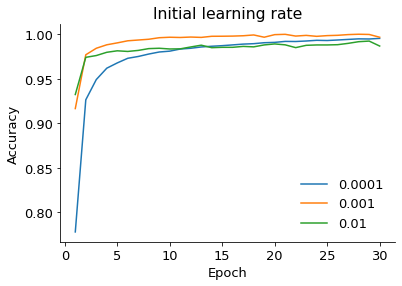

In [25]:
# Tune the initial learning rate
fit_arg = {'X_train':X_train_r,'Y_train':Y_train_oh,'X_val':X_val_r,'Y_val':Y_val_oh}

legend = []

for val in [1E-4,1E-3,1E-2]:

    model = create_keras_model(learning_rate=val)

    train_accuracy = fit_keras_model(model, **fit_arg)[0]

    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy)
    
    legend.append(str(val))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend, frameon=False)
plt.title('Initial learning rate')
set_spines()

Using a value of 10<sup>-4</sup> leads to a more smooth variation but needs many more epochs to converge to a value near the optimum. We will use a value of 10<sup>-3</sup> and tune the learning rate's decay rate to get a smoother variation. Also, using 20 epochs to train the model seems enough.

In [26]:
create_arg = {'learning_rate':0.001}
fit_arg['epochs'] = 20

In [27]:
def compare_keras_fit_param(create_fun, create_arg, fit_fun, fit_arg, tuning_param, legend=None):
    '''Compares the models built with the specified hyperparameters.'''

    if legend == None:
        legend = [str(val) for val in tuning_param[1]]

    for val in tuning_param[1]:

        model = create_fun(**create_arg)

        train_accuracy = fit_fun(model, **fit_arg, **{tuning_param[0]:val})[0]

        plt.plot(range(1, len(train_accuracy) + 1), train_accuracy)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(legend, frameon=False)
    plt.title(tuning_param[0])
    set_spines()

Train accuracy: 99.77%; Validation accuracy: 98.86%; Training time: 186.8s
Train accuracy: 99.95%; Validation accuracy: 98.95%; Training time: 177.6s
Train accuracy: 99.69%; Validation accuracy: 98.67%; Training time: 188.6s


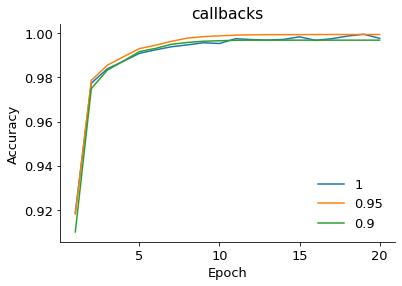

In [28]:
# Tune the decay rate of the learning rate
vals = [1,0.95,0.9]
schedulers = [[LearningRateScheduler(lambda epoch,lr,val=val: lr*val**epoch)] for val in vals]

compare_keras_fit_param(create_keras_model, create_arg, fit_keras_model, fit_arg, ('callbacks',schedulers),
                        [str(val) for val in vals])

A decay rate of 0.95 leads to the best results. Now let’s tune the batch size.

Train accuracy: 100.00%; Validation accuracy: 98.96%; Training time: 224.5s
Train accuracy: 99.95%; Validation accuracy: 98.94%; Training time: 185.4s
Train accuracy: 99.59%; Validation accuracy: 98.65%; Training time: 170.3s


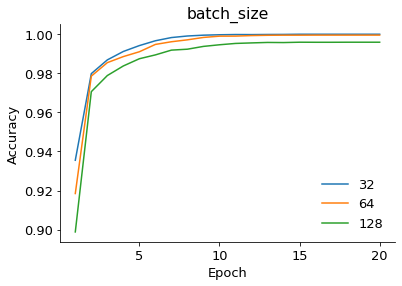

In [29]:
# Tune the batch size
fit_arg['callbacks'] = schedulers[1]

compare_keras_fit_param(create_keras_model, create_arg, fit_keras_model, fit_arg, ('batch_size',[32,64,128]))

A batch size of 32 yields the best results.

In [55]:
fit_arg['batch_size'] = 32

We will now tune the following hyperparameters used for creating the models:
* Number of filters of the convolution layers;
* Number of units of the first dense layer;
* Kernel size of the convolution layers;
* Rates of the dropout layers.

Train accuracy: 99.99%; Validation accuracy: 98.93%; Training time: 234.6s
Train accuracy: 100.00%; Validation accuracy: 99.15%; Training time: 321.9s
Train accuracy: 100.00%; Validation accuracy: 99.10%; Training time: 631.2s
Train accuracy: 100.00%; Validation accuracy: 99.18%; Training time: 1514.5s


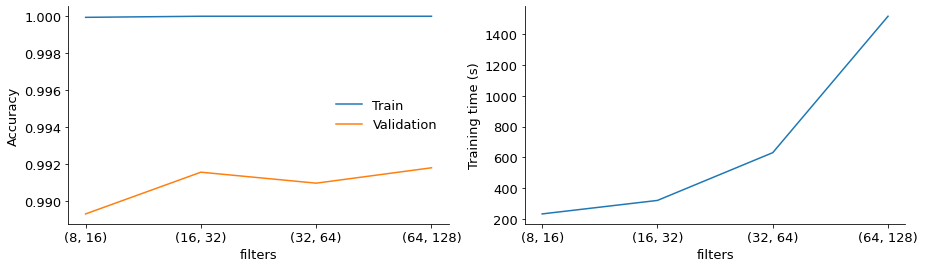

In [61]:
# Tune the number of filters of the convolution layers
vals = [(val,2*val) for val in [8,16,32,64]]

compare_model_param(create_keras_model, create_arg, fit_keras_model, fit_arg, ('filters',vals),
                    xticks_labels=[str(val) for val in vals])

Using 16 and 32 filters leads to the best results.

In [62]:
create_arg['filters'] = (16,32)

Train accuracy: 100.00%; Validation accuracy: 99.00%; Training time: 291.7s
Train accuracy: 100.00%; Validation accuracy: 99.10%; Training time: 323.8s
Train accuracy: 100.00%; Validation accuracy: 99.11%; Training time: 373.5s


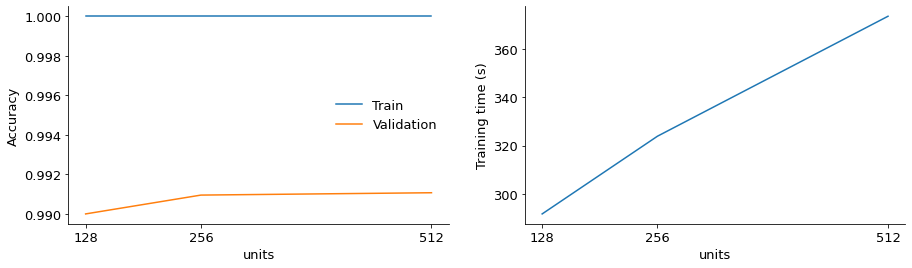

In [70]:
# Tune the number of units of the first dense layer
compare_model_param(create_keras_model, create_arg, fit_keras_model, fit_arg, ('units',[128,256,512]))

Using 256 units yields the best results without compromising the training time.

In [71]:
create_arg['units'] = 256

Train accuracy: 100.00%; Validation accuracy: 99.15%; Training time: 208.9s
Train accuracy: 100.00%; Validation accuracy: 99.17%; Training time: 324.1s
Train accuracy: 100.00%; Validation accuracy: 99.13%; Training time: 498.8s


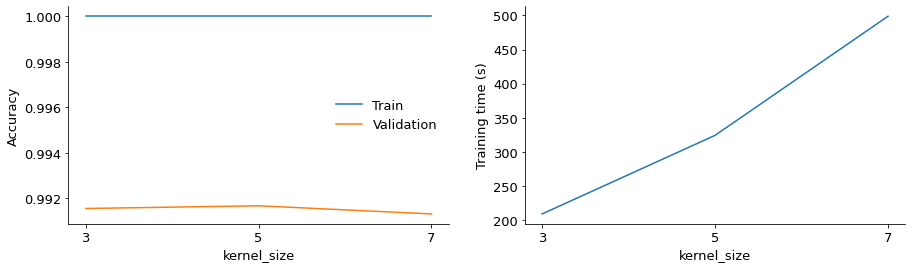

In [72]:
# Tune the kernel size of the convolution layers
compare_model_param(create_keras_model, create_arg, fit_keras_model, fit_arg, ('kernel_size',[3,5,7]))

A kernel of size 3 seems a good compromise between accuracy and efficiency.

In [73]:
create_arg['kernel_size'] = 3

Train accuracy: 100.00%; Validation accuracy: 99.10%; Training time: 214.4s
Train accuracy: 100.00%; Validation accuracy: 99.06%; Training time: 210.4s
Train accuracy: 99.96%; Validation accuracy: 99.08%; Training time: 212.5s
Train accuracy: 99.92%; Validation accuracy: 99.11%; Training time: 213.7s
Train accuracy: 99.84%; Validation accuracy: 99.00%; Training time: 210.5s


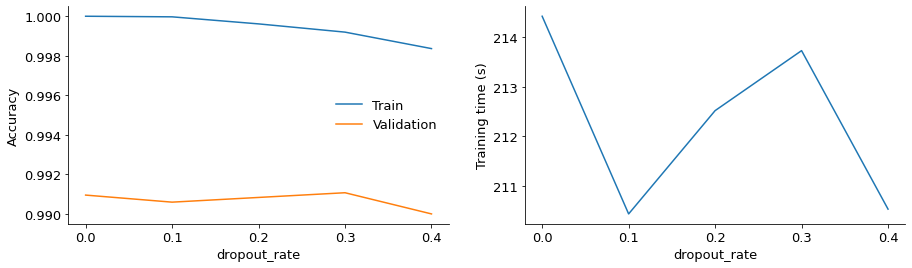

In [74]:
# Tune the rate of the third dropout layer (after dense layer)
vals = np.arange(0,0.5,0.1)

compare_model_param(create_keras_model, create_arg, fit_keras_model, fit_arg, ('dropout_rate',[(0,0,val) for val in vals]),
                    xticks_labels=['{:.1f}'.format(val) for val in vals])

Train accuracy: 99.89%; Validation accuracy: 99.05%; Training time: 214.4s
Train accuracy: 99.73%; Validation accuracy: 99.15%; Training time: 213.2s
Train accuracy: 99.50%; Validation accuracy: 99.23%; Training time: 212.4s
Train accuracy: 99.12%; Validation accuracy: 99.14%; Training time: 212.6s
Train accuracy: 98.66%; Validation accuracy: 99.04%; Training time: 206.7s


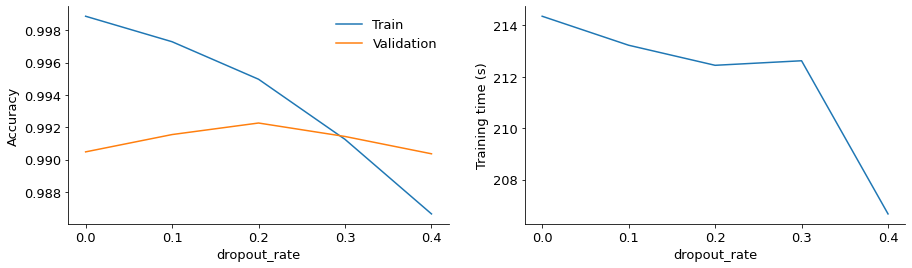

In [75]:
# Tune the rate of the first two dropout layers (after convolution layers)
compare_model_param(create_keras_model, create_arg, fit_keras_model, fit_arg, ('dropout_rate',[(val,val,0.3) for val in vals]),
                    xticks_labels=['{:.1f}'.format(val) for val in vals])

A dropout rate of 0.2 for the first two layers, and a rate of 0.3 for the last layer, yield the best results. Now let's add batch normalization layers and data augmentation to improve the performance of our model. The Keras class [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is used for generating image data, and the parameters used are described in [this](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist) notebook done by Chris Deotte.

Train accuracy: 97.93%; Validation accuracy: 99.33%; Training time: 443.5s


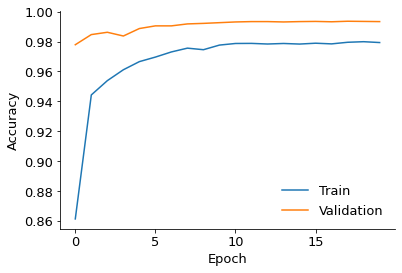

In [76]:
# Create the model
model = keras.Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(n_px,n_px,1)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(keras.optimizers.Adam(0.001), 'categorical_crossentropy', ['accuracy'])

# Create image data generator
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)

# Fit the model using the optimised hyperparameters
train_accuracy, val_accuracy, _ = fit_keras_model(model, X_train_r, Y_train_oh, datagen, X_val_r, Y_val_oh, 32, 20,
                                                  schedulers[1])

plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], frameon=False)
set_spines()

Now let’s look at the wrongly predicted digits. The confusion matrix is shown on the left subplot of the figure below. Because the number of digits predicted correctly is much higher than those mislabeled, we mainly see the matrix’s diagonal. Its colour does not vary much because we have a uniform distribution of digits’ types. The right subplot shows the confusion matrix with its diagonal filled with zeros to highlight the wrong predictions.

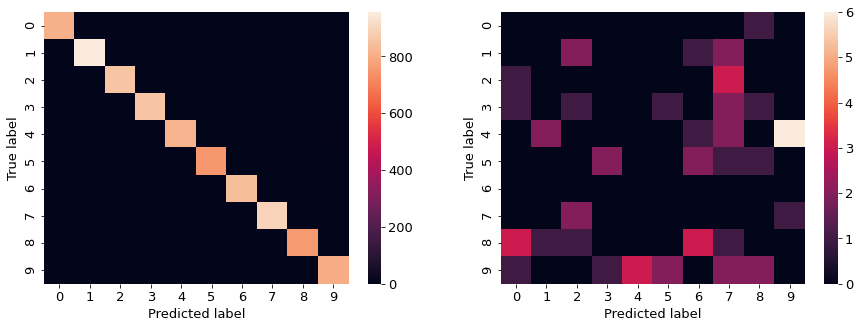

In [106]:
cm = confusion_matrix(Y_val, predictions)

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm)
plt.xlabel("Predicted label")
plt.ylabel("True label")
np.fill_diagonal(cm, 0)

plt.subplot(1, 2, 2)
sns.heatmap(cm)
plt.xlabel("Predicted label")
plt.ylabel("True label");

The first row of the following matrix is the predicted label, and the second row is the sum of the elements of each column of the confusion matrix. E.g., 13 digits were wrongly predicted to be 7.

In [117]:
print(np.vstack((np.arange(10),cm.sum(axis=0))))

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 6  3  6  3  3  3  7 13  5  7]]


The first row of the following matrix is the true label, and the second row is the sum of the elements of each row of the confusion matrix. E.g., the digits 4 and 9 have 11 wrong predictions each.

In [118]:
print(np.vstack((np.arange(10),cm.sum(axis=1))))

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  5  4  6 11  6  0  3  9 11]]


Now let’s plot 40 digits, randomly selected, that have wrong predictions. The title of each plot is the predicted label. We can observe several of the cases mentioned before. E.g., several times, the digit 2 was wrongly predicted to be 7.

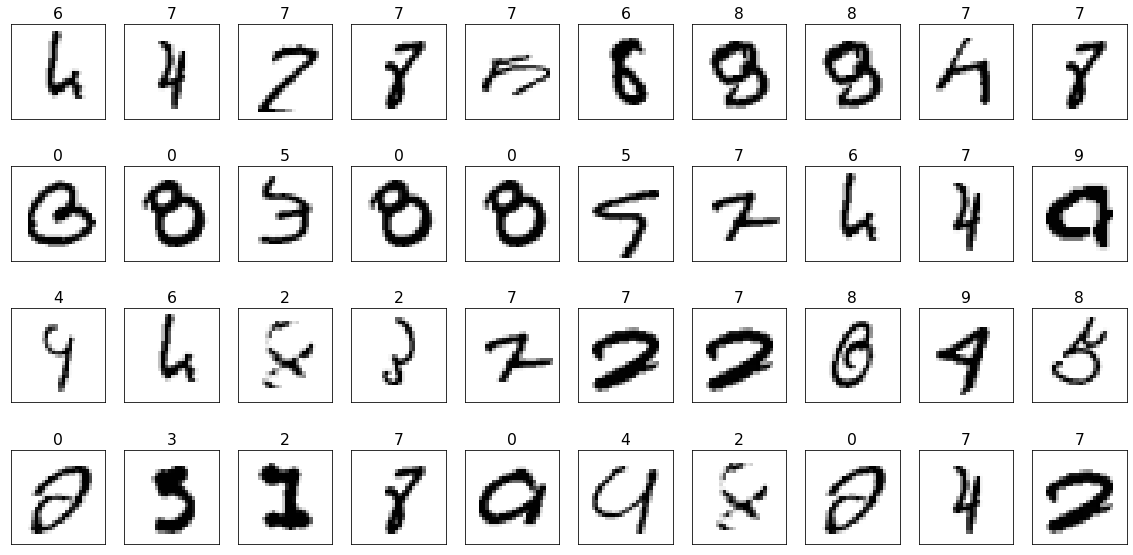

In [77]:
predictions = model.predict(X_val_r).argmax(axis=1)
wrong_label = Y_val != predictions

plot_digits((X_val.values[wrong_label] + 0.5)*255, predictions[wrong_label], 40)

Let’s calculate the predictions for the test set.

In [79]:
# Fit the model using the original training set
model = keras.models.clone_model(model)
model.compile(keras.optimizers.Adam(0.001), 'categorical_crossentropy', ['accuracy'])

train_accuracy = fit_keras_model(model, X_train_o.values.reshape(-1,n_px,n_px,1),
                                 keras.utils.to_categorical(Y_train_o, num_classes=10), datagen, None, None, 32, 25,
                                 schedulers[1])[0]

# Predict class labels for test set and save them to file
save_submission(model.predict(X_test_r).argmax(axis=1), 'submission_3.csv')

Train accuracy: 98.18%; Training time: 673.0s


The test set predictions were submitted to Kaggle, and an accuracy of 99.25% was obtained.

# Conclusions and further developments

The following table shows the accuracies and training times of the different types of models. The logistic regression is clearly not a good choice for this type of applications. Using a CNN leads to the best results but also requires much more time to train. It would be interesting to tune a smaller CNN and see if we could obtain an accuracy and efficiency better then those of the fully connected NR. The accuracy of the CNN can be further improved by using ensemble methods and collecting more data. For the latter, we recommend paying particular attention to the digits 4, 7 and 9.

Model | Accuracy (%) | Training time (s)
--- | --- | ---
Logistic regression | 92.10 | 61.5
Fully connected neural network | 97.85 | 126.0
Convolutional neural network | 99.25 | 673.0

# Acknowledgements

These excellent notebooks inspired some of the code used in this notebook:
* [MNIST Logistic Regression Baseline](https://www.kaggle.com/tunguz/mnist-logistic-regression-baseline) by Bojan Tunguz
* [How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist) by Chris Deotte
* [How to score 97%, 98%, 99%, and 100%](https://www.kaggle.com/c/digit-recognizer/discussion/61480) by Chris Deotte